In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [5]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# Below: For quartic latency functions:
def solve_CBCP_direct(tau, B, v_I_array, v_E_array, \
                         a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
                         a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):

    num_in = v_I_array.shape[0]
    num_el = v_E_array.shape[0]
    
    # y_el: \hat y_1, \tilde y_1, y_2, ..., \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3 * num_el)
    # y_in: y_1, y_2, ..., y_1, y_2
    y_in = cp.Variable(2 * num_in)
    
    c_el_ex = np.tile(np.array([1, 1, 0]), num_el)
    c_in_ex = np.tile(np.array([1, 0]), num_in)
    c_el_gp = np.tile(np.array([0, 0, 1]), num_el)
    c_in_gp = np.tile(np.array([0, 1]), num_in)
    
    func = 1/5 * a_ex[4] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 5)
    func += 1/4 * a_ex[3] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 4)
    func += 1/3 * a_ex[2] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 3)
    func += 1/2 * a_ex[1] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 2)
    func += a_ex[0] * (c_el_ex @ y_el + c_in_ex @ y_in)
    func += 1/5 * a_gp[4] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 5)
    func += 1/4 * a_gp[3] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 4)
    func += 1/3 * a_gp[2] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 3)
    func += 1/2 * a_gp[1] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 2)
    func += a_gp[0] * (c_el_gp @ y_el + c_in_gp @ y_in)
    
    for v_I_index, v_I in enumerate(v_I_array):
        func += y_in[v_I_index * 3] * tau / v_I 
    for v_E_index, v_E in enumerate(v_E_array):
        func += y_el[v_E_index * 2] * tau / v_E

    objective = cp.Minimize(func)
        
    C_el = np.kron(np.eye(num_in), np.array([1, 1, 1]))
    C_in = np.kron(np.eye(num_el), np.array([1, 1]))
    c_el_ex_budget = np.array([0, 1, 0])
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [C_el @ y_el == 1, C_in @ y_in == 1]
    
    for v_E_index, v_E in enumerate(v_E_array):
        unit_g = np.zeros(len(v_E_array))
        unit_g[v_E_index] = 1
        c_el_ex_budget_g = np.kron(unit_g, c_el_ex_budget)
        constraints += [(c_el_ex_budget_g @ y_el) * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
#     # The optimal value for x is stored in `x.value`.
#     print("In solve_CBCP_direct, y_el.value:", y_el.value)
#     print("In solve_CBCP_direct, y_in.value:", y_in.value)

    return y_el.value, y_in.value

In [6]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_array, v_E_array, y_el, y_in, \
                a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
                a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):
    
    num_in = v_I_array.shape[0]
    num_el = v_E_array.shape[0]
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    c_el_ex = np.tile(np.array([1, 1, 0]), num_el)
    c_in_ex = np.tile(np.array([1, 0]), num_in)
    c_el_gp = np.tile(np.array([0, 0, 1]), num_el)
    c_in_gp = np.tile(np.array([0, 1]), num_in)
    
    ell_ex = a_ex[4] * (c_el_ex @ y_el + c_in_ex @ y_in)**4 \
            + a_ex[3] * (c_el_ex @ y_el + c_in_ex @ y_in)**3 \
            + a_ex[2] * (c_el_ex @ y_el + c_in_ex @ y_in)**2 \
            + a_ex[1] * (c_el_ex @ y_el + c_in_ex @ y_in) \
            + a_ex[0]
    
    ell_gp = a_gp[4] * (c_el_gp @ y_el + c_in_gp @ y_in)**4 \
            + a_gp[3] * (c_el_gp @ y_el + c_in_gp @ y_in)**3 \
            + a_gp[2] * (c_el_gp @ y_el + c_in_gp @ y_in)**2 \
            + a_gp[1] * (c_el_gp @ y_el + c_in_gp @ y_in) \
            + a_gp[0]
    
    c_el_ex_toll = np.tile(np.array([1, 0, 0]), num_el)
    c_in_ex_toll = np.tile(np.array([1, 0]), num_in)
        
    c_el_ex_v = np.kron(v_E_array, np.array([1, 1, 0]))
    c_in_ex_v = np.kron(v_I_array, np.array([1, 0]))
    c_el_gp_v = np.kron(v_E_array, np.array([0, 0, 1]))
    c_in_gp_v = np.kron(v_I_array, np.array([0, 1]))
    
    obj_E = tau * c_el_ex_toll @ y_el + ell_ex * (c_el_ex_v @ y_el) + ell_gp * (c_el_gp_v @ y_el) 
    obj_R = tau * (c_el_ex_toll @ y_el + c_in_ex_toll @ y_in)
    obj_I = tau * c_in_ex_toll @ y_in + ell_ex * (c_in_ex_v @ y_in) + ell_gp * (c_in_gp_v @ y_in)
    
#     print("ell_ex:", ell_ex)
#     print("ell_gp:", ell_gp)
#     print("obj_E:", obj_E)
#     print("obj_R:", obj_R)

#     print("tau:", tau)
#     print("c_in_ex_toll @ y_in:", c_in_ex_toll @ y_in)
#     print("v_I:", v_I)
#     print("ell_ex:", ell_ex)
#     print("c_in_ex @ y_in:", c_in_ex @ y_in)
#     print("ell_gp:", ell_gp)
#     print("c_in_gp @ y_in:", c_in_gp @ y_in)
    
#     print("obj_I:", obj_I)

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [7]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    # Case 1:
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    # Case 2:
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    # Case 3:
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    # Case 4:
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    # Case 5:
    elif 0 <= B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    # Case 6:
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

## Chinmay's Algorithm:

In [12]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I_array = np.array([1.0])
v_E_array = np.array([0.6])
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 0.5
delta_bar = 0.5

welfare_list = []

tau[0] = 0.8
B[0] = 0.2

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] < B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])


    y_el, y_in = solve_CBCP_direct(tau = tau[i], B = B[i],\
                                   v_I_array = v_I_array, v_E_array = v_E_array, a_ex = a, a_gp = a)

#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_direct(tau = tau_perturbed[i], B = B_perturbed[i], \
                                                       v_I_array = v_I_array, v_E_array = v_E_array, a_ex = a, a_gp = a)
    
#     print("y_el:", y_el)
#     print("y_in:", y_in)
#     print("y_el_perturbed:", y_el_perturbed)
#     print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I_array = v_I_array, v_E_array = v_E_array, \
                          y_el = y_el, y_in = y_in, a_ex = a, a_gp = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I_array = v_I_array, v_E_array = v_E_array, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a_ex = a, a_gp = a)
    
    welfare_list.append(welfare)
    
#     def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, \
#                 a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
#                 a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0]))
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
#         print("tau[0:10]:", tau[0:10])
#         print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

min_welfare = min(welfare_list)
argmin_welfare_list = welfare_list.index(min(welfare_list))
argmin_tau = tau[argmin_welfare_list]
argmin_B = B[argmin_welfare_list]

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [-0.9329919   0.35989738]
tau[i]: 0.7
B[i]: 0.3
tau_perturbed[i]: 0.39869024466958236
B_perturbed[i]: 0.39869024466958236
welfare: 1.713292632955236
welfare_perturbed: 1.6000407090399857

Iter: 1
w_i: [0.06307631 0.99800871]
tau[i]: 0.550569772399379
B[i]: 0.35764202998019645
tau_perturbed[i]: 0.6118371331734495
B_perturbed[i]: 0.6118371331734495
welfare: 1.7157506988174203
welfare_perturbed: 1.6000509114917123

Iter: 2
w_i: [ 0.66053148 -0.75079835]
tau[i]: 0.5592485061251553
B[i]: 0.49495905621547276
tau_perturbed[i]: 0.7366953218670562
B_perturbed[i]: 0.2932627220104032
welfare: 1.7715708665483283
welfare_perturbed: 1.7174285320788625

Iter: 3
w_i: [-0.92979472  0.36807849]
tau[i]: 0.597678045518914
B[i]: 0.4512778146642886
tau_perturbed[i]: 0.45426340050685565
B_perturbed[i]: 0.45426340050685565
welfare: 1.758438002515559
welfare_perturbed: 1.6000639564002372

Iter: 4
w_i: [0.8130443  0.58220183]
tau[i]: 0.4799972935059208
B[i]: 0.4799972935059208
tau_perturbed[i]: 0.

In [13]:
print("min(welfare_list):", min(welfare_list))
print("argmin_tau:", argmin_tau)
print("argmin_B:", argmin_B)

min(welfare_list): 1.6000406097516717
argmin_tau: 0.3999529162574139
argmin_B: 0.3999529162574139


## Grid Search:

In [14]:
# tau = 0.5
# B = 0.5
# v_I = 1.0
# v_E = 0.6
# a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

# y_el_point_5, y_in_point_5 = solve_CBCP_direct(tau = tau, B = B, v_I_array = np.array([v_I]), v_E_array = np.array([v_E]),\
#                                                a_ex = a, a_gp = a)

# welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_array = np.array([v_I]), v_E_array = np.array([v_E]), \
#                                                   y_el = y_el_point_5, y_in = y_in_point_5, \
#                                                   a_ex = a, a_gp = a)


In [15]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I_array = np.array([1.0])
v_E_array = np.array([0.6])
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0


grid_size = 0.02
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.ones((tau_arr.shape[0], B_arr.shape[0])) * 100
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_direct(tau = tau, B = B,\
                                   v_I_array = v_I_array, v_E_array = v_E_array, a_ex = a, a_gp = a)
            
#             def solve_CBCP_direct(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_array = v_I_array, v_E_array = v_E_array, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a_ex = a, a_gp = a)
        
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.04
B: 0.02

tau: 0.06
B: 0.02

tau: 0.06
B: 0.04

tau: 0.08
B: 0.02

tau: 0.08
B: 0.04

tau: 0.08
B: 0.06

tau: 0.1
B: 0.02

tau: 0.1
B: 0.04

tau: 0.1
B: 0.06

tau: 0.1
B: 0.08

tau: 0.12
B: 0.02

tau: 0.12
B: 0.04

tau: 0.12
B: 0.06

tau: 0.12
B: 0.08

tau: 0.12
B: 0.1

tau: 0.14
B: 0.02

tau: 0.14
B: 0.04

tau: 0.14
B: 0.06

tau: 0.14
B: 0.08

tau: 0.14
B: 0.1

tau: 0.14
B: 0.12

tau: 0.16
B: 0.02

tau: 0.16
B: 0.04

tau: 0.16
B: 0.06

tau: 0.16
B: 0.08

tau: 0.16
B: 0.1

tau: 0.16
B: 0.12

tau: 0.16
B: 0.14

tau: 0.18
B: 0.02

tau: 0.18
B: 0.04

tau: 0.18
B: 0.06

tau: 0.18
B: 0.08

tau: 0.18
B: 0.1

tau: 0.18
B: 0.12

tau: 0.18
B: 0.14

tau: 0.18
B: 0.16

tau: 0.2
B: 0.02

tau: 0.2
B: 0.04

tau: 0.2
B: 0.06

tau: 0.2
B: 0.08

tau: 0.2
B: 0.1

tau: 0.2
B: 0.12

tau: 0.2
B: 0.14

tau: 0.2
B: 0.16

tau: 0.2
B: 0.18

tau: 0.22
B: 0.02

tau: 0.22
B: 0.04

tau: 0.22
B: 0.06

tau: 0.22
B: 0.08

tau: 0.22
B: 0.1

tau: 0.22
B: 0.12

tau: 0.22
B: 0.14

tau: 0.22
B: 0.16

tau: 0.22
B:


tau: 0.62
B: 0.2

tau: 0.62
B: 0.22

tau: 0.62
B: 0.24

tau: 0.62
B: 0.26

tau: 0.62
B: 0.28

tau: 0.62
B: 0.3

tau: 0.62
B: 0.32

tau: 0.62
B: 0.34

tau: 0.62
B: 0.36

tau: 0.62
B: 0.38

tau: 0.62
B: 0.4

tau: 0.62
B: 0.42

tau: 0.62
B: 0.44

tau: 0.62
B: 0.46

tau: 0.62
B: 0.48

tau: 0.62
B: 0.5

tau: 0.62
B: 0.52

tau: 0.62
B: 0.54

tau: 0.62
B: 0.56

tau: 0.62
B: 0.58

tau: 0.62
B: 0.6

tau: 0.64
B: 0.02

tau: 0.64
B: 0.04

tau: 0.64
B: 0.06

tau: 0.64
B: 0.08

tau: 0.64
B: 0.1

tau: 0.64
B: 0.12

tau: 0.64
B: 0.14

tau: 0.64
B: 0.16

tau: 0.64
B: 0.18

tau: 0.64
B: 0.2

tau: 0.64
B: 0.22

tau: 0.64
B: 0.24

tau: 0.64
B: 0.26

tau: 0.64
B: 0.28

tau: 0.64
B: 0.3

tau: 0.64
B: 0.32

tau: 0.64
B: 0.34

tau: 0.64
B: 0.36

tau: 0.64
B: 0.38

tau: 0.64
B: 0.4

tau: 0.64
B: 0.42

tau: 0.64
B: 0.44

tau: 0.64
B: 0.46

tau: 0.64
B: 0.48

tau: 0.64
B: 0.5

tau: 0.64
B: 0.52

tau: 0.64
B: 0.54

tau: 0.64
B: 0.56

tau: 0.64
B: 0.58

tau: 0.64
B: 0.6

tau: 0.64
B: 0.62

tau: 0.66
B: 0.02

tau


tau: 0.84
B: 0.08

tau: 0.84
B: 0.1

tau: 0.84
B: 0.12

tau: 0.84
B: 0.14

tau: 0.84
B: 0.16

tau: 0.84
B: 0.18

tau: 0.84
B: 0.2

tau: 0.84
B: 0.22

tau: 0.84
B: 0.24

tau: 0.84
B: 0.26

tau: 0.84
B: 0.28

tau: 0.84
B: 0.3

tau: 0.84
B: 0.32

tau: 0.84
B: 0.34

tau: 0.84
B: 0.36

tau: 0.84
B: 0.38

tau: 0.84
B: 0.4

tau: 0.84
B: 0.42

tau: 0.84
B: 0.44

tau: 0.84
B: 0.46

tau: 0.84
B: 0.48

tau: 0.84
B: 0.5

tau: 0.84
B: 0.52

tau: 0.84
B: 0.54

tau: 0.84
B: 0.56

tau: 0.84
B: 0.58

tau: 0.84
B: 0.6

tau: 0.84
B: 0.62

tau: 0.84
B: 0.64

tau: 0.84
B: 0.66

tau: 0.84
B: 0.68

tau: 0.84
B: 0.7000000000000001

tau: 0.84
B: 0.72

tau: 0.84
B: 0.74

tau: 0.84
B: 0.76

tau: 0.84
B: 0.78

tau: 0.84
B: 0.8

tau: 0.84
B: 0.8200000000000001

tau: 0.86
B: 0.02

tau: 0.86
B: 0.04

tau: 0.86
B: 0.06

tau: 0.86
B: 0.08

tau: 0.86
B: 0.1

tau: 0.86
B: 0.12

tau: 0.86
B: 0.14

tau: 0.86
B: 0.16

tau: 0.86
B: 0.18

tau: 0.86
B: 0.2

tau: 0.86
B: 0.22

tau: 0.86
B: 0.24

tau: 0.86
B: 0.26

tau: 0.86
B


tau: 1.0
B: 0.84

tau: 1.0
B: 0.86

tau: 1.0
B: 0.88

tau: 1.0
B: 0.9

tau: 1.0
B: 0.92

tau: 1.0
B: 0.9400000000000001

tau: 1.0
B: 0.96

tau: 1.0
B: 0.98

Time: 79.35928702354431


In [16]:
# tau = 0.5
# B = 0.4
# v_I = 1.0
# v_E = 0.6

# y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
#                 = solve_CBCP_direct(tau = tau, B = B, v_I_array = np.array([v_I]), v_E_array = np.array([v_E]), a_ex = a, a_gp = a)
            
# #             def solve_CBCP_direct(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
# welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_array = np.array([v_I]), v_E_array = np.array([v_E]), \
#                                                               y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
#                                                               a_ex = a, a_gp = a)

In [17]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1]]


argmin_tau:
 0.36

argmin_B:
 0.02


1.5715357186433188

Text(0, 0.5, 'Budget')

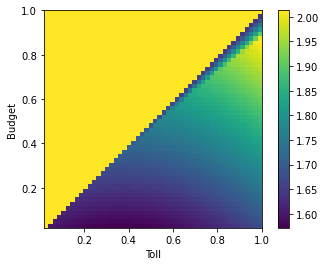

In [33]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

## Test:

In [ ]:
# Test:

grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Scratch Work:

In [ ]:
# Test:

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_elig = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_inel = cp.Variable(2)

a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

tau = 0.5
B = 0.4

func = 1/5 * a[4] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 5)
func += 1/4 * a[3] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 4)
func += 1/3 * a[2] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 3)
func += 1/2 * a[1] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 2)
func += a[0] * (y_elig[0] + y_elig[1] + y_inel[0])
func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
func += 1/5 * a[4] * cp.power(y_elig[2] + y_inel[1], 5)
func += 1/4 * a[3] * cp.power(y_elig[2] + y_inel[1], 4)
func += 1/3 * a[2] * cp.power(y_elig[2] + y_inel[1], 3)
func += 1/2 * a[1] * cp.power(y_elig[2] + y_inel[1], 2)
func += a[0] * (y_elig[2] + y_inel[1])

objective = cp.Minimize(func)


constraints = []
constraints += [y_elig >= 0, y_inel >= 0]
constraints += [cp.sum(y_elig) == 1, cp.sum(y_inel) == 1]
constraints += [y_elig[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("y_elig.value:", np.round(y_elig.value, 4) )
print("y_inel.value:", np.round(y_inel.value, 4) )
print()



# power(x, p)

